In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=df92cb0847783e5c09c88aaf49c93ad9435a281de108293d9a813fe091c7ee57
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [3]:
# Copy data into VM
# !cp -r /content/drive/MyDrive/Colab\ Notebooks/AI4Thyroid ./

In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [5]:
import sys
sys.path.append('./drive/MyDrive/Colab Notebooks/')
from AI4Thyroid import windows_utils_hf as util

In [6]:
from sklearn import model_selection, metrics

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm import tqdm

from PIL import Image

In [7]:
# zip1 = '/content/drive/MyDrive/Colab\ Notebooks/AI4Thyroid-20240117T130331Z-001.zip'
# zip2 = '/content/drive/MyDrive/Colab\ Notebooks/AI4Thyroid-20240117T130331Z-002.zip'

repo_fp = Path('/content/drive/MyDrive/Colab Notebooks/AI4Thyroid')
# repo_fp = Path('./AI4Thyroid')
tz_fp = repo_fp / 'Tanzania-Data'
summary_fp = tz_fp / 'TAN_THYROID_summary.csv'

In [8]:
summary_file = pd.read_csv(summary_fp, index_col=0)

In [9]:
summary_file

,Scan ID,Cytology no.,Diagnosis/Bethesda system,Bethesda actual,Histopathology,Present,Present (Manual)
0,TAN001,C-11-22,Malignant,6,Anaplastic carcinoma,1,exist
1,TAN002,C-20-22,Benign nodule,2,Simple Nodular Goitre,1,exist
2,TAN003,C-53-23,Benign nodule,2,Simple Nodular Goitre,1,exist
3,TAN004,C-36-23,Benign nodule,2,Simple Nodular Goitre,1,exist
4,TAN005,C-373-20,Benign nodule,2,Simple Nodular Goitre,1,exist
...,...,...,...,...,...,...,...
100,TAN101,C-076-23,Carcinoma,6,No biopsy,1,exist
101,TAN102,C-285-23,Goitre/thyroiditis,2,Cystic goitre,1,exist
102,TAN103,CP-01-23,Carcinoma,6,Anaplastic carcinoma,1,exist
103,TAN104,C-302-23,Colloid goitre,2,Colloid goitre,1,exist


In [10]:
summary_file['Scan ID'].nunique()

105

<Axes: >

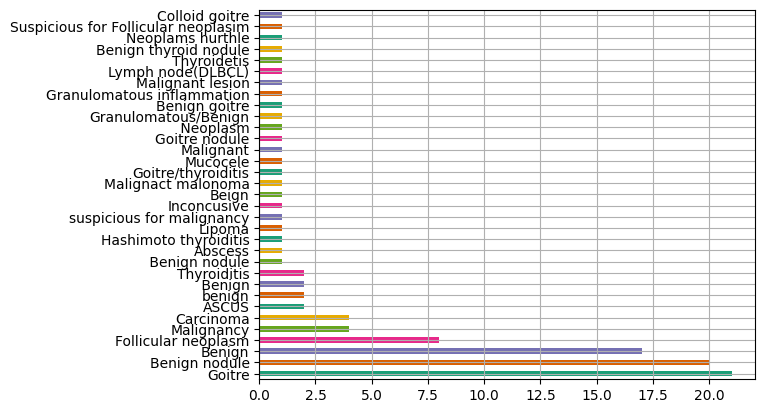

In [11]:
summary_file['Diagnosis/Bethesda system'].value_counts().plot(kind='barh',color=sns.palettes.mpl_palette('Dark2'), grid=True)

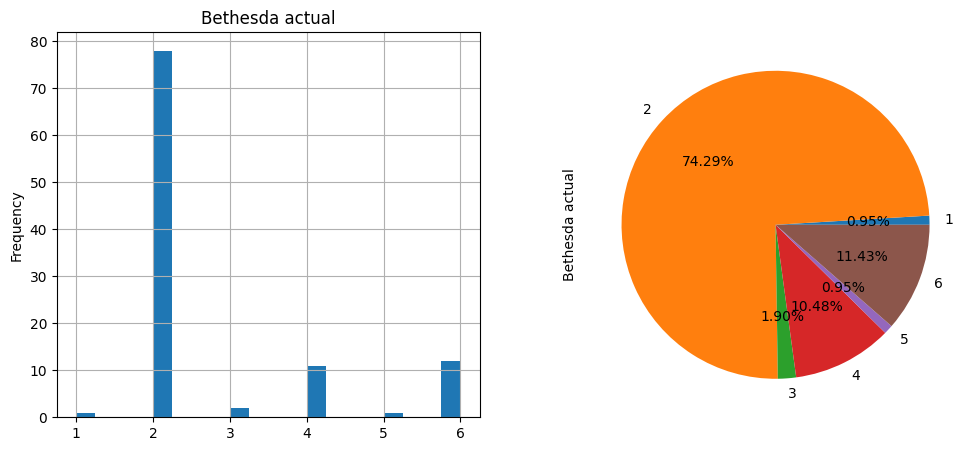

In [12]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
summary_file['Bethesda actual'].plot(kind='hist', bins=20, title='Bethesda actual',ax=axs[0], grid=True)
summary_file['Bethesda actual'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
def reload_or_create_classification_summary():
    filename = 'TAN_THYROID_classification_summary.csv'
    filepath = tz_fp / filename
    if not filepath.exists():
        print('Create new file')
        df = []
        for i, r in summary_file.iterrows():
            id, label = r['Scan ID'], r['Bethesda actual']
            id_fp = tz_fp / id
            img_files = list(id_fp.iterdir())
            img_files = [i for i in img_files if (i.name.endswith('.jpg')) and (i.is_file())]
            for i in img_files:
                df.append((str(i), label))
        df = pd.DataFrame(data=df, columns=['img_path', 'label'])
        df['dataset'] = np.random.choice(['train','val','test'],p=[0.6,0.2,0.2], size=len(df))
        df.to_csv(filepath)
    else:
        print('Reload summary file')
        df = pd.read_csv(filepath, index_col=0)
    return df


In [14]:
clf_summary = reload_or_create_classification_summary()

Reload summary file


<Axes: ylabel='label'>

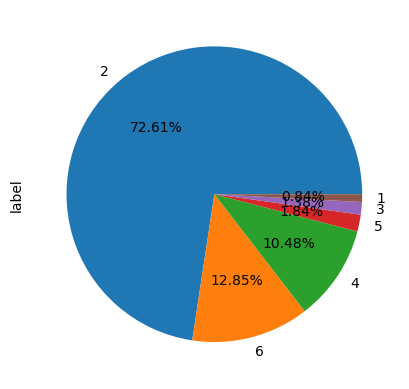

In [15]:
clf_summary['label'].value_counts().plot(kind='pie', autopct='%.2f%%')

In [16]:
clf_summary.groupby('label')['dataset'].value_counts(normalize=True).to_frame('count').reset_index().pivot(index='dataset', columns='label', values='count')

label,1,2,3,4,5,6
dataset,,,,,,
test,0.090909,0.210748,0.222222,0.124088,0.083333,0.190476
train,0.636364,0.583772,0.666667,0.613139,0.708333,0.648810
val,0.272727,0.205479,0.111111,0.262774,0.208333,0.160714


In [17]:
clf_summary['dataset'].value_counts(normalize=True)

train    0.599082
val      0.205050
test     0.195868
Name: dataset, dtype: float64

In [18]:
clf_summary.head()

,img_path,label,dataset
0,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,6,test
1,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,6,train
2,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,6,train
3,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,6,train
4,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,6,test


In [19]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [20]:
batch_size=8

In [21]:
# prompt: i need pytorch dataset that read from dataframe

class ThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        label = self.dataframe['label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image_path, image, label


In [22]:
test_df = clf_summary[clf_summary['dataset']=='test'].reset_index(drop=True)

In [23]:
testset = ThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [25]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(1280, test_df['label'].nunique())
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 64.5MB/s]


Loaded pretrained weights for efficientnet-b0


In [26]:
# Test
model.load_state_dict(torch.load(str(repo_fp /'efficientnet-b0-classification.pt')))
model.eval()
test_loss = 0.0
test_acc = 0.0
test_f1 = 0.0
test_auc = 0.0
for batch_idx, (filepath, data, target) in enumerate(tqdm(testloader)):
    data, target = data.to(device), target.to(device)
    target = target.clamp(min=0, max=5)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    test_acc += accuracy_score(output.argmax(dim=1), target)
    # test_f1 += f1_score(output.argmax(dim=1), target)
    # test_auc += roc_auc_score(target, output[:, 1])
test_loss /= len(testloader)
test_acc /= len(testloader)
test_f1 /= len(testloader)
test_auc /= len(testloader)

print('Test Loss: {:.4f} \tTest Acc: {:.4f} \tTest F1: {:.4f} \tTest AUC: {:.4f}'.format(test_loss, test_acc, test_f1, test_auc))


100%|██████████| 32/32 [01:34<00:00,  2.96s/it]

Test Loss: 0.4089 	Test Acc: 0.8867 	Test F1: 0.0000 	Test AUC: 0.0000


In [27]:
test_loss, test_acc

(0.4088523674872704, 0.88671875)

In [28]:
def plot_images(filepaths, images, labels, predictions):
  """Plot a batch of images, their labels, and their predictions."""
  fig, axs = plt.subplots(2, 4, figsize=(20, 7))
  for i in range(4):
    img = images[i]
    img = img.cpu().permute(1, 2, 0)
    img = np.clip(img, 0, 1)
    origin_img = Image.open(filepaths[i])
    axs[0, i].imshow(origin_img)
    axs[0, i].set_title(f'Label: {labels[i]}')
    axs[1, i].imshow(img)
    axs[1, i].set_title(f'Pred: {predictions[i]}')
  plt.show()
  print('===================================================================================================================================================')
  print('===================================================================================================================================================')
  print('===================================================================================================================================================')

In [29]:
# Get a batch of images from the test set.
all_labels, all_predictions = [], []
for batch_idx, (filepaths, images, labels) in enumerate(tqdm(testloader)):
    labels = labels.clamp(min=0, max=5)
    # Make predictions on the images.
    predictions = model(images.to(device)).argmax(dim=1)
    # Plot the images, their labels, and their predictions.
    all_labels.extend(labels)
    all_predictions.extend(predictions)
    if batch_idx < 5:
        plot_images(filepaths, images, labels, predictions)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
from sklearn import metrics

In [31]:
np.unique(all_labels), np.unique(all_predictions)

(array([1, 2, 3, 4, 5]), array([1, 2, 3, 4, 5]))

In [32]:
print(metrics.classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.94      0.94      0.94       200
           3       0.67      0.50      0.57         4
           4       0.56      0.53      0.55        17
           5       0.75      0.79      0.77        34

    accuracy                           0.89       256
   macro avg       0.78      0.75      0.77       256
weighted avg       0.89      0.89      0.89       256



In [33]:
metrics.accuracy_score(all_labels, all_predictions)

0.88671875

In [45]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (7, 7));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)

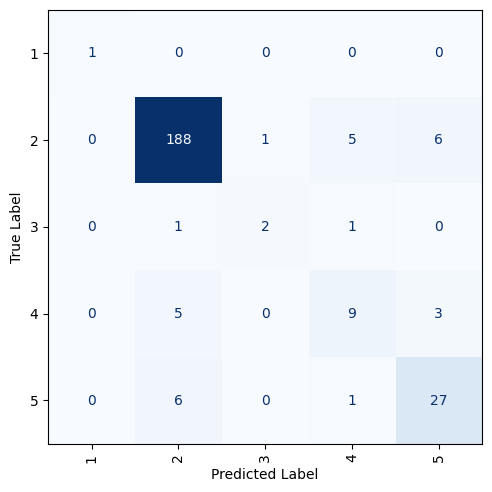

In [46]:
plot_confusion_matrix(all_labels, all_predictions, [1,2,3,4,5])